In [ ]:
# !pip install kaggle

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path = '/content/drive/My Drive/Dataset/images_001.zip'  # Update with your actual file path
data_dir = '/content/data_dir'

# Create the target directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

print(f'Dataset extracted to {data_dir}')

Dataset extracted to /content/data_dir


In [ ]:
dataset_path = '/content/data_dir/images'

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random

device = "cuda" if torch.cuda.is_available() else "cpu"

# Define image size
low_res_size = (128, 128)   # Low-Resolution image
high_res_size = (512, 512)  # High-Resolution image

# Define dataset class
class SRDataset(Dataset):
    def __init__(self, dataset_path, augment=True):
        self.image_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        # self.augment = augment

        # Define normalization for 3 RGB channels
        self.normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

        # Low-resolution transformations
        self.lr_transform = transforms.Compose([
            transforms.Resize(low_res_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            self.normalize
        ])

        # High-resolution transformations
        self.hr_transform = transforms.Compose([
            transforms.Resize(high_res_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            self.normalize
        ])

        # Data augmentation transformations
        # self.augment_transforms = transforms.Compose([
        #     transforms.RandomHorizontalFlip(p=0.5),  # Flip images randomly
        #     transforms.RandomRotation(degrees=5),   # Rotate randomly ±5 degrees
        #     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02)  # Improve diversity
        # ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img = Image.open(self.image_files[idx]).convert("RGB")  # Load and convert to RGB

        # if self.augment:
        #     img = self.augment_transforms(img)  # Apply data augmentation

        hr_img = self.hr_transform(img)  # High-res version
        lr_img = self.lr_transform(img)  # Low-res version
        return lr_img, hr_img

# Load dataset
dataset = SRDataset(dataset_path, augment=True)

In [ ]:
split_size = 0.2
split_index = int(len(dataset) * (1 - split_size))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [split_index, len(dataset) - split_index])

In [ ]:
len(train_dataset), len(val_dataset)

(3999, 1000)

In [ ]:
# Create DataLoader
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Test data loading
for lr, hr in train_dataloader:
    print("Low-Res Image Shape:", lr.shape)
    print("High-Res Image Shape:", hr.shape)
    break


Low-Res Image Shape: torch.Size([8, 3, 128, 128])
High-Res Image Shape: torch.Size([8, 3, 512, 512])


In [ ]:

print(f"Total images in dataset: {len(dataset)}")

Total images in dataset: 4999


In [ ]:
import matplotlib.pyplot as plt

# Get one sample from the dataset
lr_img, hr_img = dataset[2]
lr_img.shape, hr_img.shape
# Convert tensors to NumPy arrays for visualization


(torch.Size([3, 128, 128]), torch.Size([3, 512, 512]))

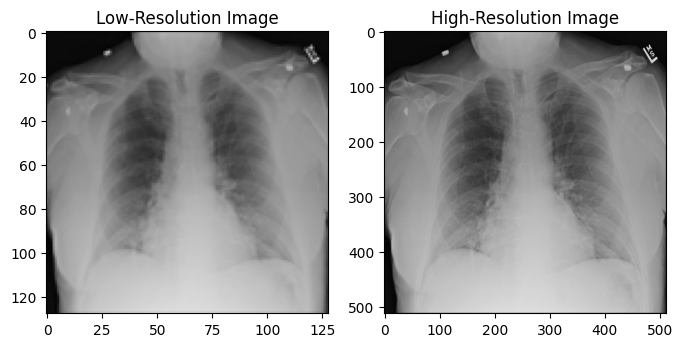

In [ ]:
lr_img = lr_img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Denormalize
hr_img = hr_img.permute(1, 2, 0).numpy() * 0.5 + 0.5

# Plot
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(lr_img)
plt.title("Low-Resolution Image")

plt.subplot(1, 2, 2)
plt.imshow(hr_img)
plt.title("High-Resolution Image")

plt.show()

In [ ]:
import torch
import torch.nn as nn
import math

class ResidualBlock(nn.Module):
    def __init__(self, channels, use_dropout=False, use_bn=False):
        super(ResidualBlock, self).__init__()
        layers = [
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        ]

        if use_bn:
            layers.append(nn.BatchNorm2d(channels))  # Insert BN after first conv
        layers.append(nn.PReLU())

        if use_dropout:
            layers.append(nn.Dropout(0.2))

        layers.append(nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.block(x)  # Residual connection


class Generator(nn.Module):
    def __init__(self, num_res_blocks=12, scale_factor=4):
        super(Generator, self).__init__()
        self.scale_factor = scale_factor
        assert math.log2(scale_factor).is_integer(), "Scale factor must be a power of 2"

        # Initial conv
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )

        # Residual blocks
        self.res_blocks = nn.Sequential(*[ResidualBlock(64, use_dropout=True, use_bn=True) for _ in range(num_res_blocks)])

        # Mid conv (no activation to match original SRGAN)
        self.mid_conv = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        # Upsampling
        self.upsample = self.make_upsample_layers(scale_factor)

        # Final output layer
        self.final = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4),
            nn.Tanh()  # Output in range [-1, 1]
        )

        self._initialize_weights()

    def make_upsample_layers(self, scale_factor):
        layers = []
        num_blocks = int(math.log2(scale_factor))
        for _ in range(num_blocks):
            layers += [
                nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
                nn.PixelShuffle(2),
                nn.PReLU()
            ]
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, a=math.sqrt(5), mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        out1 = self.initial(x)
        out2 = self.res_blocks(out1)
        out3 = self.mid_conv(out2)
        out3 += out1  # Global skip connection
        out4 = self.upsample(out3)
        return self.final(out4)

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, stride=1, use_norm=True):
            layers = [spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1))]
            if use_norm:
                layers.append(nn.InstanceNorm2d(out_channels, affine=True))  # Affine=True to learn scale & shift
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            discriminator_block(3, 64, stride=1, use_norm=False),  # First layer, no normalization
            discriminator_block(64, 128, stride=2),
            discriminator_block(128, 256, stride=2),
            discriminator_block(256, 512, stride=2),
            spectral_norm(nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1))  # PatchGAN-style
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global pooling for full-image discrimination
            nn.Flatten()
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, a=math.sqrt(5), mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        features = self.features(x)
        out = self.classifier(features)
        return out

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class VGGFeatureExtractor(nn.Module):
    def __init__(self, layer=36, use_input_norm=True):
        """
        Extracts features from VGG19 for perceptual/content loss.

        Args:
            layer (int): Layer up to which features are extracted.
            use_input_norm (bool): Whether to apply ImageNet normalization.
        """
        super().__init__()
        vgg19 = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features
        self.feature_extractor = nn.Sequential(*list(vgg19.children())[:layer])
        self.feature_extractor.eval()

        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        self.use_input_norm = use_input_norm
        if use_input_norm:
            self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
            self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, x):
        """
        Args:
            x (Tensor): Input image tensor of shape (B, 3, H, W), values in [0, 1] or [0, 255].

        Returns:
            Tensor: VGG feature map from specified layer.
        """
        if self.use_input_norm:
            x = x / 255.0 if x.max() > 1 else x
            x = (x - self.mean) / self.std
        return self.feature_extractor(x)


In [ ]:
generator = Generator()
discriminator = Discriminator()
feature_extractor = VGGFeatureExtractor()

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
feature_extractor.to(device)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 106MB/s]


VGGFeatureExtractor(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3

In [ ]:
generator_path = '/content/drive/MyDrive/Models/generator_epoch_6 (1).pth'  # change this path
generator.load_state_dict(torch.load(generator_path, map_location=device))

# discriminator_path = '/content/drive/MyDrive/Models/discriminator_epoch_9.pth'  # change this path
# discriminator.load_state_dict(torch.load(discriminator_path, map_location=device))

<All keys matched successfully>

In [ ]:
import torch.nn as nn
import torch.optim as optim

# --- Loss Functions ---
adversarial_loss = nn.MSELoss()       # Stable for GANs compared to BCE
content_loss = nn.SmoothL1Loss()      # Robust to outliers, smoother gradients than MSE
pixel_loss = nn.L1Loss()              # Preserves fine detail better than MSE

# --- Optimizers ---
learning_rate_G = 2e-4
learning_rate_D = 2e-4

optimizer_G = optim.AdamW(
    generator.parameters(),
    lr=learning_rate_G,
    betas=(0.5, 0.999),
    weight_decay=1e-6  # Helps with generalization
)

optimizer_D = optim.Adam(
    discriminator.parameters(),
    lr=learning_rate_D,
    betas=(0.5, 0.999)
)

# --- Learning Rate Schedulers ---
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=5, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=5, gamma=0.5)


In [ ]:
import torch
import torchvision.utils as vutils
import os

def save_image(tensor, filename, normalize=True):
    """
    Saves a PyTorch tensor as an image file.

    Parameters:
        tensor (torch.Tensor): Image tensor (BxCxHxW).
        filename (str): Path to save the image.
        normalize (bool): Whether to normalize pixel values to [0,1].
    """
    os.makedirs(os.path.dirname(filename), exist_ok=True)  # Ensure directory exists
    vutils.save_image(tensor, filename, normalize=normalize)


In [ ]:
import time
import os
import torch
import torchvision.utils as vutils
from torch.cuda.amp import autocast, GradScaler

os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 2
save_interval = 1
scaler = GradScaler()

# Overwrite schedulers with custom steps (if needed)
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=20, gamma=0.7)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=20, gamma=0.7)

for epoch in range(num_epochs):
    start_time = time.time()

    for i, (lr_imgs, hr_imgs) in enumerate(train_dataloader):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        # Fix: Change batch size to 8 to match the data loader's batch size
        real_labels = torch.ones((hr_imgs.shape[0], 1), device=device)
        fake_labels = torch.zeros((hr_imgs.shape[0], 1), device=device)
        # hr_imgs += 0.05 * torch.randn_like(hr_imgs)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        with autocast():
            real_preds = discriminator(hr_imgs)
            real_loss = adversarial_loss(real_preds, real_labels)

            fake_imgs = generator(lr_imgs).detach()
            fake_preds = discriminator(fake_imgs)
            fake_loss = adversarial_loss(fake_preds, fake_labels)

            d_loss = (real_loss + fake_loss) / 2

        scaler.scale(d_loss).backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=0.5)
        scaler.step(optimizer_D)
        scaler.update()

        # --- Train Generator ---
        optimizer_G.zero_grad()
        with autocast():
            fake_imgs = generator(lr_imgs)
            pred_fake = discriminator(fake_imgs)
            g_adv_loss = adversarial_loss(pred_fake, real_labels)

            fake_features = feature_extractor(fake_imgs)
            real_features = feature_extractor(hr_imgs)
            g_content_loss = content_loss(fake_features, real_features)
            g_pixel_loss = pixel_loss(fake_imgs, hr_imgs)

            g_loss = 0.006 * g_adv_loss + 1.0 * g_content_loss + 1.0 * g_pixel_loss

        scaler.scale(g_loss).backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=0.5)
        scaler.step(optimizer_G)
        scaler.update()

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{i}/{len(train_dataloader)}] | "
                  f"D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    scheduler_G.step()
    scheduler_D.step()

    vutils.save_image(fake_imgs[:4], f"results/epoch_{epoch+1}.png", normalize=True)

    if (epoch + 1) % save_interval == 0:
        torch.save(generator.state_dict(), f"models/generator_epoch_{epoch+1}.pth")
        torch.save(discriminator.state_dict(), f"models/discriminator_epoch_{epoch+1}.pth")

    print(f"Epoch {epoch+1} completed in {time.time() - start_time:.2f} seconds.")

<ipython-input-24-a1e84dcbc1b2>:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-24-a1e84dcbc1b2>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-24-a1e84dcbc1b2>:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/2] | Batch [0/500] | D Loss: 0.1138 | G Loss: 0.0708
Epoch [1/2] | Batch [10/500] | D Loss: 0.0574 | G Loss: 0.0680
Epoch [1/2] | Batch [20/500] | D Loss: 0.0237 | G Loss: 0.0665
Epoch [1/2] | Batch [30/500] | D Loss: 0.0706 | G Loss: 0.0677
Epoch [1/2] | Batch [40/500] | D Loss: 0.0324 | G Loss: 0.0665
Epoch [1/2] | Batch [50/500] | D Loss: 0.0416 | G Loss: 0.0738
Epoch [1/2] | Batch [60/500] | D Loss: 0.0834 | G Loss: 0.0676
Epoch [1/2] | Batch [70/500] | D Loss: 0.0282 | G Loss: 0.0708
Epoch [1/2] | Batch [80/500] | D Loss: 0.0335 | G Loss: 0.0696
Epoch [1/2] | Batch [90/500] | D Loss: 0.0456 | G Loss: 0.0682
Epoch [1/2] | Batch [100/500] | D Loss: 0.0578 | G Loss: 0.0671
Epoch [1/2] | Batch [110/500] | D Loss: 0.0516 | G Loss: 0.0799
Epoch [1/2] | Batch [120/500] | D Loss: 0.1025 | G Loss: 0.0641
Epoch [1/2] | Batch [130/500] | D Loss: 0.0253 | G Loss: 0.0737
Epoch [1/2] | Batch [140/500] | D Loss: 0.0669 | G Loss: 0.0546
Epoch [1/2] | Batch [150/500] | D Loss: 0.0636 | G 

In [ ]:
import os
import torch
import torchvision.utils as vutils
from torch.cuda.amp import autocast
from tqdm import tqdm
import torchvision.transforms as transforms

# === Paths & Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("test_results", exist_ok=True)


# === Inference with Dataloader ===
with torch.no_grad():
    for idx, (lr_imgs, hr_imgs) in enumerate(tqdm(test_dataloader)):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        with autocast():
            sr_imgs = generator(lr_imgs)

        # Clamp if output is in [-1, 1]
        sr_imgs = sr_imgs.clamp(-1, 1)
        sr_imgs = (sr_imgs + 1) / 2  # Normalize to [0, 1] for saving
        lr_imgs = (lr_imgs + 1) / 2
        hr_imgs = (hr_imgs + 1) / 2

        # Resize lr_imgs to match the size of sr_imgs and hr_imgs before concatenation
        lr_imgs_resized = transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.BICUBIC)(lr_imgs)

        # Optional: save side-by-side image comparison
        comparison = torch.cat([lr_imgs_resized, sr_imgs, hr_imgs], dim=0)  # Concatenate along batch dimension
        vutils.save_image(comparison, f"test_results/compare_{idx+1}.png", nrow=lr_imgs.shape[0], normalize=True)

        # Or just save SR
        # vutils.save_image(sr_imgs, f"test_results/sr_{idx+1}.png", normalize=True)

print("✅ Inference complete. Check test_results folder.")

  0%|          | 0/125 [00:00<?, ?it/s]<ipython-input-23-e4a11301c839>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 125/125 [05:06<00:00,  2.46s/it]

✅ Inference complete. Check test_results folder.
